# Tutorial: Informed Search Algorithms

This tutorial shows how we can combine motion primitives of vehicles, i.e., short trajectory segments, with informed search algorithms to find feasible trajectories that connect the **initial state** and the **goal region** of a given planning problem.

## 0. Preparation
Before you proceed with this tutorial, make sure that

* you have gone through the tutorials on **CommonRoad Input-Output** and **Uninformed Search Algorithms**.
* you have installed all necessary modules for CommonRoad Search according to the installation manual.

Let's start with importing relevant modules and classes for setting up the automaton and the CommonRoad (CR) scenario.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
path_notebook = os.getcwd()

# add the root folder to python path
sys.path.append(os.path.join(path_notebook, "../../"))

# add the 1_search_algorithms folder to python path
sys.path.append(os.path.join(path_notebook, "../"))

import matplotlib.pyplot as plt

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

from SMP.motion_planner.motion_planner import MotionPlanner
from SMP.maneuver_automaton.maneuver_automaton import ManeuverAutomaton
from SMP.motion_planner.utility import plot_primitives, display_steps

## 1. Loading CR Scenario and Planning Problem
In the next step, we load a CommonRoad scenario and its planning problem, which should be solved with the search algorithms. The meaning of the symbols in a scenario are explained as follows:
* **Dot**: initial state projected onto the position domain
* **Red rectangle**: static obstacle
* **Yellow rectangle**: goal region projected onto the position domain

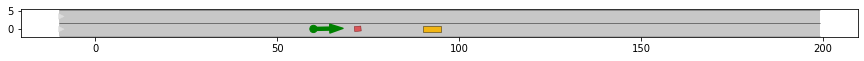

In [2]:
# load scenario
path_scenario = os.path.join(path_notebook, "../../scenarios/tutorial/")
id_scenario = 'ZAM_Tutorial_Urban-3_2'

# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
    
# plot the scenario and the planning problem set
plt.figure(figsize=(15, 5))
renderer = MPRenderer()

scenario.draw(renderer)
planning_problem_set.draw(renderer)

plt.gca().set_aspect('equal')
plt.margins(0, 0)
renderer.render()
plt.show()

## 2. Generating a Maneuver Automaton

In the following, we load the pre-generated motion primitives from an XML-File, and generate a **Maneuver Automaton** out of them.
The maneuver automaton used for this tutorial consists of 7 motion primitives; the connectivity within the motion primitives are also computed and stored. Some additional explanations on the motion primitives:
* The motion primitives are generated for the *Kinematic Single Track Model* (see [Vehicle Model Documentation](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf)) with parameters taken from vehicle model *BMW320i* (id_type_vehicle=2). 
* The motion primitives have a constant driving velocity of 9 m/s, varying steering angles with constant steering angle velocity, and a duration of 0.5 seconds. We assume constant input during this period.
* The motion primitives are generated for all combinations of the steering angles of values 0 rad and 0.2 rad at the initial state and the final state, thereby producing 2 (initial states) x 2 (final states) = 4 primitives. Except for the primive moving straight (with 0 rad steering angle at the initial and the final states), the remaining 3 left-turning primitives are mirrored with regard to the x-axis, resulting in a total number of 7 motion primitives.
* Two motion primitives are considered connectable if the velocity and the steering angle of the final state of the preceding primitive are equal to those of the initial state of the following primitive.

Reading motion primitives from file V_9.0_9.0_Vstep_0_SA_-0.2_0.2_SAstep_0.4_T_0.5_Model_BMW320i.xml


  0%|          | 0/7 [00:00<?, ?it/s]

Automaton created.
Number of loaded primitives: 7


<Figure size 576x576 with 0 Axes>

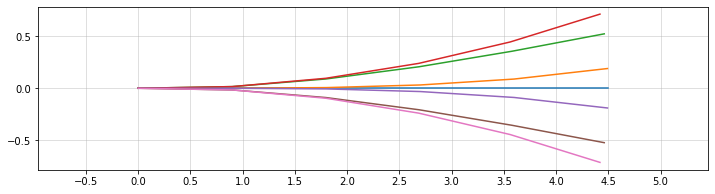

In [3]:
# load the xml with stores the motion primitives
name_file_motion_primitives = 'V_9.0_9.0_Vstep_0_SA_-0.2_0.2_SAstep_0.4_T_0.5_Model_BMW320i.xml'

# generate automaton
automaton = ManeuverAutomaton.generate_automaton(name_file_motion_primitives)

# plot motion primitives
plt.figure(figsize=(8,8))

plot_primitives(automaton.list_primitives)

## 3. Search algorithms
Next, we demonstrate the search results for the following algorithms:
1. Greedy-Best-First-Search (GBFS)
2. A* Search (A*)

For each of the algorithms, we create a corresponding motion planner implemented in the **MotionPlanner** class, with the scenario, the planning problem, and the generated automaton as the input. The source codes are located at **SMP/motion_planner/search_algorithms/**

After executing the code block for every algorithm, you will see a **"visualize"** button directly beneath the **"iteration"** slider. Click the **"visualize"** button and let the search algorithm run through; once it's completed, you can use the slider to examine all intermediate search steps. Meaning of colors and lines are explained as follows:
* **Yellow solid:** frontier 
* **Yellow dashed:** collision
* **Red solid:** currently exploring
* **Gray solid:** explored
* **Green solid:** final solution

### 3.1 Greedy-Best-First Search (GBFS)
As mentioned in the tutorial on uninformed search algorithms, GBFS is based on the Best-First Search algorithm, and uses the heuristic cost h(n) as the evaluation function f(n), i.e. GBFS always opts for the node that has the least h(n).

As an exemplary heuristic, we simply estimate the time to reach the goal from the current state. This is estimated through obtaining the Euclidean distance between the state and the goal region, divided by the velocity.

In [4]:
# construct motion planner
planner_GBFS = MotionPlanner.GreedyBestFirstSearch(scenario=scenario, 
                                                   planning_problem=planning_problem,
                                                   automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_GBFS.state_initial, planner_GBFS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_GBFS.execute_search, 
              config=planner_GBFS.config_plot)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

### 3.2 A* Search (A*)
The evaluation function of A* is expressed by f(n)= g(n) + h(n), where g(n) is the accumulated path cost, and h(n) the heuristic cost to the goal region. Compared to GBFS, A* not only consideres the node with least h(n), but also takes the historical cost into consideration.

In [5]:
# construct motion planner
planner_ASTAR = MotionPlanner.AStarSearch(scenario=scenario, 
                                          planning_problem=planning_problem,
                                          automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_ASTAR.state_initial, planner_ASTAR.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_ASTAR.execute_search,
              config=planner_ASTAR.config_plot)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='Visualize'), Output()), _dom_classes=('widget-int…

In the given planning problem, A* took more steps to find the same solutio as GBFS. 

**Question:** Is this always the case? You can verify your thoughts with re-running the search algorithms on the goal-shifted scenario (refer to the tutorial on uninformed search algorithms).

**Question:** Can you further improve the heuristic function to improve the search efficiency?

## Congratulations!

You have finished the tutorial on informed search algorithms! Let's move on to the next tutorial on CommonRoad Search.